# Lecture : Graph Clustering

## Lab 01 : Standard k-means -- Solution

### Xavier Bresson, Jiaming Wang

<font color=cyan>

#### Pandu's Note:

This notebook focuses on the impact of different initialization, and K-Means inability to learn non-linear problem

</font>

In [1]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive/CS5284_2025_codes/codes/03_Graph_Clustering'
    print(path_to_file)
    # change current path to the folder containing "path_to_file"
    os.chdir(path_to_file)
    !pwd
    

In [2]:
# Load libraries
import numpy as np
import scipy.io
#%matplotlib notebook 
%matplotlib inline 
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import time
import sys; sys.path.insert(0, 'lib/')
from lib.utils import construct_kernel
from lib.utils import compute_kernel_kmeans_EM
from lib.utils import compute_kernel_kmeans_spectral
from lib.utils import compute_purity
from lib.utils import construct_knn_graph
from lib.utils import compute_ncut
from lib.utils import compute_pcut
from lib.utils import graph_laplacian
import warnings; warnings.filterwarnings("ignore")


# Gaussian Mixture Model (GMM)


In [3]:
# Load raw data images
mat = scipy.io.loadmat('datasets/GMM.mat')
X = mat['X']
n = X.shape[0] # number of data
d = X.shape[1] # number of dimension
Cgt = mat['Cgt'] - 1 # Cgt (Cluster ground truth) label
Cgt = Cgt.squeeze()
nc = len(np.unique(Cgt)) # Find how many unique labels
print(n,d,nc)

4500 2 9


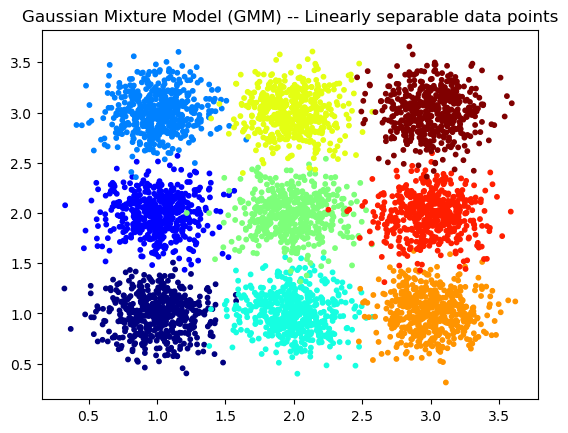

In [4]:
plt.figure(1)
size_vertex_plot = 10
plt.scatter(X[:,0], X[:,1], s=size_vertex_plot*np.ones(n), c=Cgt, cmap='jet')
plt.title('Gaussian Mixture Model (GMM) -- Linearly separable data points')
plt.show()


### Question 1: Evaluating the impact of different initializations on k-Means performance

**Initialization Methods:**
* **Constant Function:** You can use `numpy.ones()` for this initialization.
* **Random Function:** Consider `numpy.random.randint()` for random initialization.

Discuss how these initialization methods affect the clustering results on the distribution of a Gaussian Mixture Model.

<font color=cyan>
Pandu's Note:

Although it looks different, this is still fundamentally K-Means btw. It is just computed using matrix approach.

Gemini:

Here, `Ker[i, j]` stores the dot product between data point `i` and data point `j`. This is called the linear kernel. The key insight of Kernel K-means is that the distance of a point `x_i` to a cluster centroid `m_q` can be calculated using only the dot products between the data points themselves. This avoids the need to compute `m_q` directly.

</font>

In [ ]:
# Initialization
n = X.shape[0]
C_kmeans = np.ones(shape=n) # constant initialization
C_kmeans = np.random.randint(nc,size=n) # random initialization

# Linear Kernel for standard K-Means
Ker = X.dot(X.T)
print(Ker.shape)

# Loop
Cold = np.ones([n])
diffC = 1e10
Theta = np.ones(n) # Same weight for each data
Theta = np.diag(Theta)
Ones = np.ones((1,n))
En_iters = []
Clusters_iters = []; Clusters_iters.append(C_kmeans)
k = 0
while (k<50) & (diffC>1e-2):
    
    # Update iteration
    k += 1
    #print(k)
    
    # Distance Matrix D
    row = np.array(range(n))
    col = C_kmeans
    data = np.ones(n)
    F = scipy.sparse.csr_matrix((data, (row, col)), shape=(n, nc)).todense()
    O = np.diag( np.array( 1./ (Ones.dot(Theta).dot(F) + 1e-6) ).squeeze() )
    T = Ker.dot(Theta.dot(F.dot(O)))
    D = - 2* T + np.repeat( np.diag(O.dot((F.T).dot(Theta.dot(T))))[None,:] ,n,axis=0)
    #print(D.shape)
    ### LECTURE 3 SLIDE 19 ###
    
    # Extract clusters
    C_kmeans = np.array(np.argmin(D,1)).squeeze()
    Clusters_iters.append(C_kmeans)
                
    # L2 difference between two successive cluster configurations
    diffC = np.linalg.norm(C_kmeans-Cold)/np.linalg.norm(Cold)
    Cold = C_kmeans
        
    # K-Means energy
    En = np.multiply( (np.repeat(np.diag(Ker)[:,None],nc,axis=1) + D) , F)
    En_kmeans = np.sum(En)/n
    En_iters.append(En_kmeans)
    
print(k)

(4500, 4500)
13


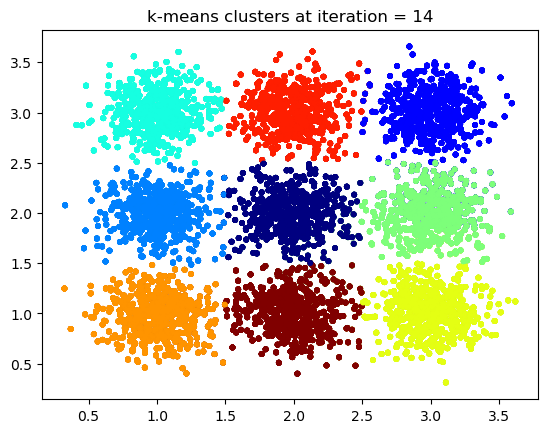

In [6]:
# Visualize k-means iterations
fig, ax = plt.subplots()
for k,C in enumerate(Clusters_iters):
    plt.scatter(X[:,0], X[:,1], s=10*np.ones(n), c=C, cmap='jet')
    plt.title('k-means clusters at iteration = ' + str(k+1) )
    display(fig)
    clear_output(wait=True)


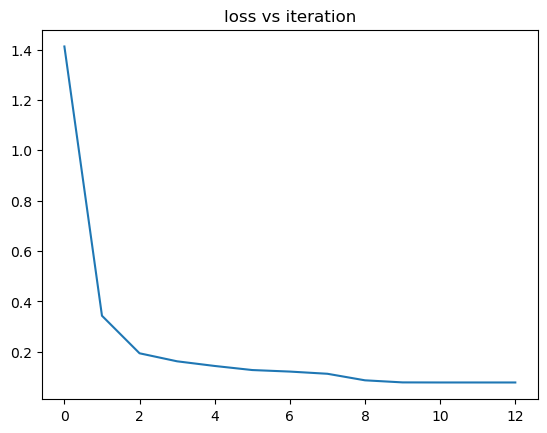

In [7]:
# Visualize loss vs iteration
plt.figure(3)
plt.plot(En_iters)
plt.title('loss vs iteration')
plt.show()


# Two concentric circles


2000 2 2


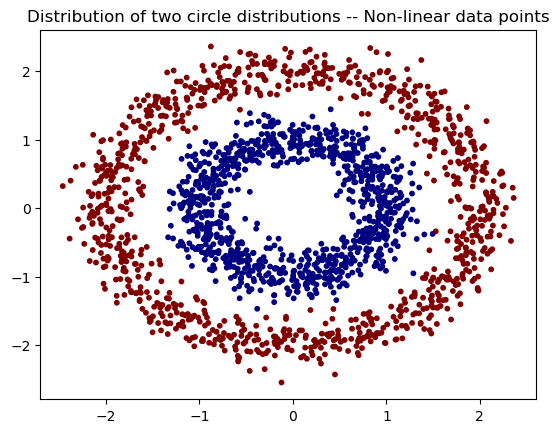

In [8]:
# Load raw data images
mat = scipy.io.loadmat('datasets/two_circles.mat')
X = mat['X']
n = X.shape[0]
d = X.shape[1]
Cgt = mat['Cgt'] - 1; Cgt = Cgt.squeeze()
nc = len(np.unique(Cgt))
print(n,d,nc)

plt.figure(10)
size_vertex_plot = 10
plt.scatter(X[:,0], X[:,1], s=size_vertex_plot*np.ones(n), c=Cgt, cmap='jet')
plt.title('Distribution of two circle distributions -- Non-linear data points')
plt.show()


### Question 2: Assessing k-Means performance with various initializations

Can you identify an initialization function that successfully separates the two classes in this dataset? 

Evaluate the effectiveness of k-means on this dataset.


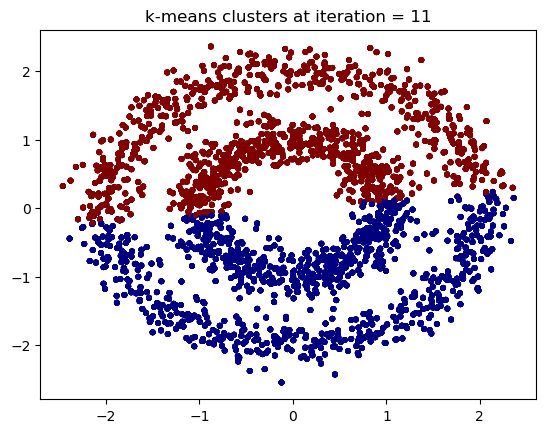

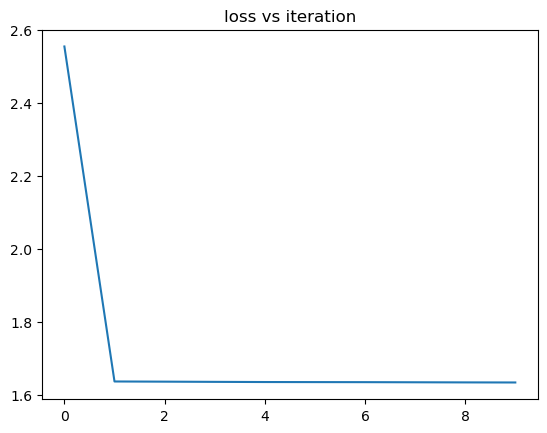

In [ ]:
# Initialization
n = X.shape[0]
C_kmeans = np.ones(shape=n) # constant initialization
C_kmeans = np.random.randint(nc,size=n) # random initialization

# Linear Kernel for standard K-Means
Ker = X.dot(X.T)
print(Ker.shape)

# Loop
Cold = np.ones([n])
diffC = 1e10
Theta = np.ones(n) # Equal weight for each data
Theta = np.diag(Theta)
Ones = np.ones((1,n))
En_iters = []
Clusters_iters = []; Clusters_iters.append(C_kmeans)
k = 0
while (k<10) & (diffC>1e-2):
    
    # Update iteration
    k += 1
    #print(k)
    
    # Distance Matrix D
    row = np.array(range(n))
    col = C_kmeans
    data = np.ones(n)
    F = scipy.sparse.csr_matrix((data, (row, col)), shape=(n, nc)).todense()
    O = np.diag( np.array( 1./ (Ones.dot(Theta).dot(F) + 1e-6) ).squeeze() )
    T = Ker.dot(Theta.dot(F.dot(O)))
    D = - 2* T + np.repeat( np.diag(O.dot((F.T).dot(Theta.dot(T))))[None,:] ,n,axis=0)
    #print(D.shape)
    ### LECTURE 3 SLIDE 19 ###
    
    # Extract clusters
    C_kmeans = np.array(np.argmin(D,1)).squeeze()
    Clusters_iters.append(C_kmeans)
                
    # L2 difference between two successive cluster configurations
    diffC = np.linalg.norm(C_kmeans-Cold)/np.linalg.norm(Cold)
    Cold = C_kmeans
        
    # K-Means energy
    En = np.multiply( (np.repeat(np.diag(Ker)[:,None],nc,axis=1) + D) , F)
    En_kmeans = np.sum(En)/n
    En_iters.append(En_kmeans)
    
print(k)

# Visualize k-means iterations
fig, ax = plt.subplots()
for k,C in enumerate(Clusters_iters):
    plt.scatter(X[:,0], X[:,1], s=10*np.ones(n), c=C, cmap='jet')
    plt.title('k-means clusters at iteration = ' + str(k+1) )
    display(fig)
    clear_output(wait=True)
    
# Visualize loss vs iteration
plt.figure(12)
plt.plot(En_iters)
plt.title('loss vs iteration')
plt.show()
